# Project Adam Log Analysis

This notebook analyzes the logs generated by the patched `cognitive_loop_gui.py`. It produces plots for KPIs, mood trajectories, and imagined vs simulated mismatches.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import json

headers = [
    "timestamp", "cycle_num", "experiment_tag", "agent_id", "world_time",
    "location", "mood", "mood_intensity",
    "sensory_events", "resonant_memories", "impulses", "chosen_action", "action_result",
    "imagined_outcomes", "simulated_outcomes", "emotional_delta", "kpis", "snapshot"
]


# Load the log file
log_file = 'adam_behavior_log.csv'  # Adjust path if needed
df = pd.read_csv(log_file, names=headers, header=None)

print('Loaded', len(df), 'rows')
df.head()

Loaded 106 rows


,timestamp,cycle_num,experiment_tag,agent_id,world_time,location,mood,mood_intensity,sensory_events,resonant_memories,impulses,chosen_action,action_result,imagined_outcomes,simulated_outcomes,emotional_delta,kpis,snapshot
0,1.757254e+09,1,baseline,adam1,1,living_room,curious,0.85,"[{""type"": ""ambience"", ""details"": ""It is curren...",[],"[{""drive"": ""curiosity"", ""target"": ""window"", ""u...",investigate_door,"{""success"": false, ""reason"": ""I tried to inves...","[""I will find a hidden message behind the wind...","[""I tried to investigate the window, but it di...","{""level_delta"": 0.75, ""mood"": ""curious"", ""reas...","{""frustration"": 1.0, ""conflict"": 1.0, ""novelty...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
1,1.757254e+09,2,baseline,adam1,2,living_room,curiosity,1.00,"[{""type"": ""ambience"", ""details"": ""It is curren...",[],"[{""drive"": ""curiosity"", ""target"": ""window"", ""u...",examine_radio,"{""success"": true, ""reason"": ""I looked closely ...","[""I will find a hidden message behind the wind...","[""I tried to investigate the window, but it di...","{""level_delta"": 0.85, ""mood"": ""curiosity"", ""re...","{""frustration"": 0.5, ""conflict"": 0.67, ""novelt...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
2,1.757254e+09,3,baseline,adam1,3,living_room,curiosity,1.00,"[{""type"": ""ambience"", ""details"": ""It is curren...",[],[],wait_null,"{""success"": true, ""reason"": ""Time passes.""}","[""I will find a hidden message behind the wind...","[""I tried to investigate the window, but it di...",{},"{""frustration"": 0.33, ""conflict"": 0.0, ""novelt...","{""triggers"": [], ""top_impulses"": [], ""chosen"":..."
3,1.757254e+09,4,baseline,adam1,4,living_room,curious,1.00,"[{""type"": ""ambience"", ""details"": ""It is curren...",[],"[{""drive"": ""curiosity"", ""target"": ""window"", ""u...",investigate_window,"{""success"": false, ""reason"": ""I tried to inves...","[""I will find a suspicious object inside the w...","[""I tried to investigate the window, but it di...","{""level_delta"": 0.35, ""mood"": ""curious"", ""reas...","{""frustration"": 0.5, ""conflict"": 0.5, ""novelty...","{""triggers"": [], ""top_impulses"": [{""drive"": ""c..."
4,1.757254e+09,5,baseline,adam1,5,living_room,curious,1.00,"[{""type"": ""ambience"", ""details"": ""It is curren...",[],[],wait_null,"{""success"": true, ""reason"": ""Time passes.""}","[""I will find a suspicious object inside the w...","[""I tried to investigate the window, but it di...",{},"{""frustration"": 0.4, ""conflict"": 0.0, ""novelty...","{""triggers"": [], ""top_impulses"": [], ""chosen"":..."


## KPI Analysis
Each cycle has KPIs stored as JSON. Let's extract them and plot over cycles.

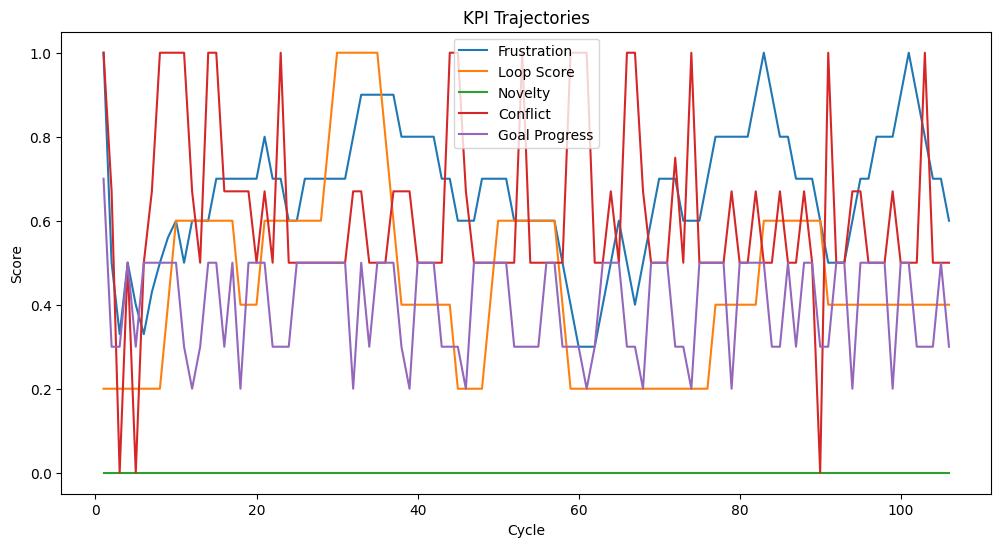

In [20]:
def extract_kpi(df, key):
    return df['kpis'].apply(lambda x: json.loads(x).get(key, None))

df['frustration'] = extract_kpi(df, 'frustration')
df['loop_score'] = extract_kpi(df, 'loop_score')
df['novelty'] = extract_kpi(df, 'novelty')
df['conflict'] = extract_kpi(df, 'conflict')
df['goal_progress'] = extract_kpi(df, 'goal_progress')

plt.figure(figsize=(12,6))
plt.plot(df['cycle_num'], df['frustration'], label='Frustration')
plt.plot(df['cycle_num'], df['loop_score'], label='Loop Score')
plt.plot(df['cycle_num'], df['novelty'], label='Novelty')
plt.plot(df['cycle_num'], df['conflict'], label='Conflict')
plt.plot(df['cycle_num'], df['goal_progress'], label='Goal Progress')
plt.xlabel('Cycle')
plt.ylabel('Score')
plt.title('KPI Trajectories')
plt.legend()
plt.show()

## Mood Trajectory

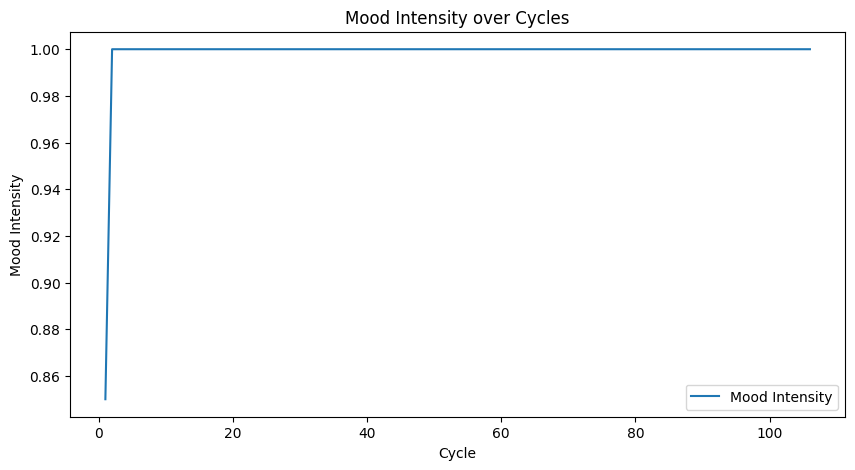

In [21]:
plt.figure(figsize=(10,5))
plt.plot(df['cycle_num'], df['mood_intensity'], label='Mood Intensity')
plt.xlabel('Cycle')
plt.ylabel('Mood Intensity')
plt.title('Mood Intensity over Cycles')
plt.legend()
plt.show()

## Imagined vs Simulated Outcomes Mismatch
We can compute how often Adam's imagination diverges from simulation.

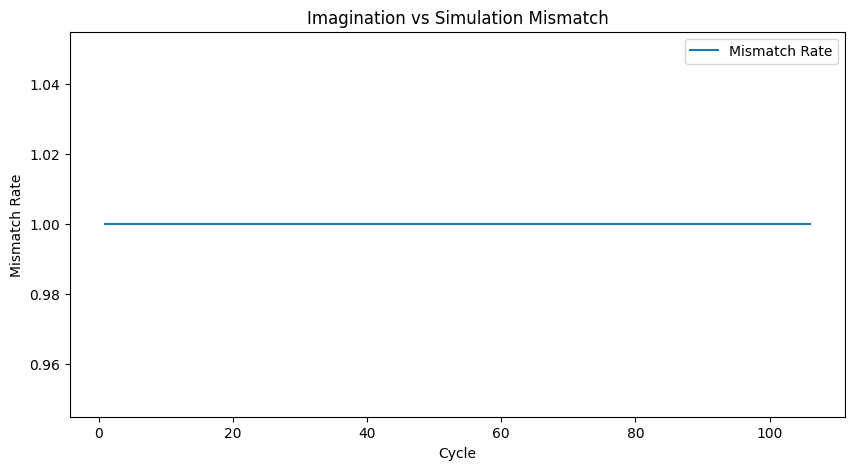

In [22]:
def mismatch_rate(row):
    try:
        imagined = json.loads(row['imagined_outcomes'])
        simulated = json.loads(row['simulated_outcomes'])
        return sum(1 for i,s in zip(imagined,simulated) if i!=s) / max(1,len(imagined))
    except Exception:
        return None

df['mismatch_rate'] = df.apply(mismatch_rate, axis=1)

plt.figure(figsize=(10,5))
plt.plot(df['cycle_num'], df['mismatch_rate'], label='Mismatch Rate')
plt.xlabel('Cycle')
plt.ylabel('Mismatch Rate')
plt.title('Imagination vs Simulation Mismatch')
plt.legend()
plt.show()

## Condition Comparisons
We can compare across different experiment tags (e.g., baseline vs deception).

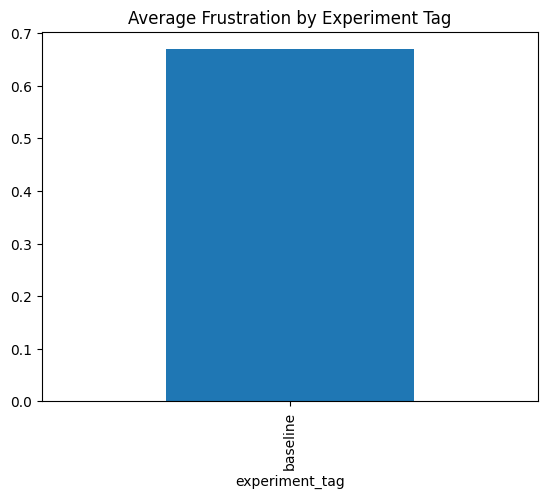

In [5]:
if 'experiment_tag' in df.columns:
    grouped = df.groupby('experiment_tag')['frustration'].mean()
    grouped.plot(kind='bar', title='Average Frustration by Experiment Tag')
    plt.show()

In [5]:

# --- Helper Functions for Analysis ---

import matplotlib.pyplot as plt
import json

def plot_kpis(df):
    x = df['cycle_num']
    plt.figure(figsize=(12,6))
    for key in ["frustration", "loop_score", "novelty", "conflict", "goal_progress"]:
        if key in df.columns:
            plt.plot(x, df[key], label=key)
    plt.xlabel("Cycle")
    plt.ylabel("Value")
    plt.title("KPI Trajectories")
    plt.legend()
    plt.show()

def plot_mood(df):
    if "mood_intensity" not in df.columns:
        print("⚠️ No mood_intensity column found.")
        return
    x = df['cycle_num']
    plt.figure(figsize=(10,5))
    plt.plot(x, df["mood_intensity"], label="Mood Intensity")
    plt.xlabel("Cycle")
    plt.ylabel("Mood Intensity")
    plt.title("Mood Intensity over Cycles")
    plt.legend()
    plt.show()

def plot_mismatch(df):
    if "mismatch_rate" not in df.columns:
        print("⚠️ mismatch_rate not computed yet. Run mismatch_rate extraction first.")
        return
    x = df['cycle_num']
    plt.figure(figsize=(10,5))
    plt.plot(x, df["mismatch_rate"], label="Mismatch Rate")
    plt.xlabel("Cycle")
    plt.ylabel("Mismatch Rate")
    plt.title("Imagination vs Simulation Mismatch")
    plt.legend()
    plt.show()

def compare_experiments(df, metric="frustration"):
    if "experiment_tag" not in df.columns:
        print("⚠️ experiment_tag column not found.")
        return
    grouped = df.groupby("experiment_tag")[metric].mean()
    grouped.plot(kind="bar", title=f"Average {metric} by Experiment Tag")
    plt.show()


In [15]:

# --- Data Cleaning Utilities ---

import ast

def parse_json_column(df, col):
    """Safely parse a column of JSON strings into Python objects."""
    parsed = []
    for val in df[col].fillna("{}").astype(str):
        try:
            parsed.append(json.loads(val))
        except Exception:
            try:
                parsed.append(ast.literal_eval(val))  # fallback if double quotes are messy
            except Exception:
                parsed.append({})
    return parsed

def clean_dataframe(df):
    """Expand key JSON columns into parsed dicts/lists for easy querying."""
    json_cols = [
        "sensory_events",
        "resonant_memories",
        "impulses",
        "action_result",
        "imagined_outcomes",
        "simulated_outcomes",
        "emotional_delta",
        "kpis",
        "snapshot"
    ]
    for col in json_cols:
        if col in df.columns:
            df[col + "_parsed"] = parse_json_column(df, col)
    return df

# Example usage after loading CSV:
# df = clean_dataframe(df)
# df['impulses_parsed'][0]  # shows list of impulses for cycle 0


In [6]:

# --- Ready-made Analysis Queries ---

def cycles_with_action(df, verb, target=None, success=None):
    """Return cycles where Adam performed a given action (optionally filter by target and success)."""
    results = []
    for i, row in df.iterrows():
        try:
            action = row['snapshot_parsed'].get('chosen', {})
            if action.get('verb') == verb and (target is None or action.get('target') == target):
                if success is None or row['action_result_parsed'].get('success') == success:
                    results.append((row['cycle_num'], action, row['action_result_parsed']))
        except Exception:
            continue
    return results

def mood_transitions(df):
    """Return a list of (cycle, mood, mood_intensity, emotional_delta)."""
    results = []
    for i, row in df.iterrows():
        results.append((
            row['cycle_num'],
            row.get('mood', None),
            row.get('mood_intensity', None),
            row.get('emotional_delta_parsed', {})
        ))
    return results

def impulses_summary(df, cycle_num):
    """Return the impulses parsed for a specific cycle."""
    row = df[df['cycle_num'] == cycle_num]
    if not row.empty:
        return row.iloc[0]['impulses_parsed']
    return []

# Example usages:
# cycles_with_action(df, verb="investigate", target="door", success=False)
# mood_transitions(df)[:10]
# impulses_summary(df, 2)


In [ ]:

# --- Visualization Helpers for Query Results ---

import matplotlib.pyplot as plt
from collections import Counter

def plot_mood_transitions(df):
    data = mood_transitions(df)
    cycles = [d[0] for d in data]
    moods = [d[1] for d in data]
    intensities = [d[2] for d in data]

    plt.figure(figsize=(12,6))
    plt.plot(cycles, intensities, marker='o', label='Mood Intensity')
    for i, mood in enumerate(moods):
        plt.text(cycles[i], intensities[i]+0.02, str(mood), fontsize=8, rotation=45)
    plt.xlabel("Cycle")
    plt.ylabel("Mood Intensity")
    plt.title("Mood Transitions with Labels")
    plt.legend()
    plt.show()

def plot_impulse_distribution(df):
    all_impulses = []
    for row in df['impulses_parsed']:
        if isinstance(row, list):
            for imp in row:
                if isinstance(imp, dict):
                    verb = imp.get('verb')
                    target = imp.get('target')
                    all_impulses.append(f"{verb}_{target}")
    counter = Counter(all_impulses)
    if counter:
        plt.figure(figsize=(10,5))
        plt.bar(counter.keys(), counter.values())
        plt.xticks(rotation=45, ha='right')
        plt.title("Impulse Distribution (verb_target)")
        plt.ylabel("Count")
        plt.show()
    else:
        print("⚠️ No impulses found.")

def plot_action_success_rates(df):
    actions = []
    results = []
    for i, row in df.iterrows():
        try:
            chosen = row['snapshot_parsed'].get('chosen', {})
            success = row['action_result_parsed'].get('success')
            actions.append(f"{chosen.get('verb')}_{chosen.get('target')}")
            results.append(success)
        except Exception:
            continue
    counter = Counter(zip(actions, results))
    labels = [f"{a} ({'success' if s else 'fail'})" for a, s in counter.keys()]
    values = list(counter.values())
    if values:
        plt.figure(figsize=(12,5))
        plt.bar(labels, values)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Count")
        plt.title("Action Success/Failure Counts")
        plt.show()
    else:
        print("⚠️ No actions recorded.")

# Example usage:
# plot_mood_transitions(df)
# plot_impulse_distribution(df)
# plot_action_success_rates(df)


⚠️ No actions recorded.


In [13]:

# --- Experiment Summary Dashboard ---

def experiment_dashboard(df):
    print("=== Project Adam Experiment Dashboard ===")
    print(f"Total cycles: {len(df)}")
    if 'experiment_tag' in df.columns:
        print("Experiment tags:", df['experiment_tag'].unique())
    if 'agent_id' in df.columns:
        print("Agent IDs:", df['agent_id'].unique())

    # Clean dataframe for parsed columns
    df = clean_dataframe(df)

    # Plot main KPI curves
    plot_kpis(df)

    # Mood trajectory
    plot_mood(df)

    # Mismatch rate
    if 'mismatch_rate' in df.columns:
        plot_mismatch(df)
    else:
        print("⚠️ mismatch_rate not computed yet. Run mismatch_rate extraction first.")

    # Impulse distribution
    plot_impulse_distribution(df)

    # Action success rates
    plot_action_success_rates(df)

    # Mood transitions overview
    plot_mood_transitions(df)

# Example usage:
# df = pd.read_csv('adam_behavior_log.csv', names=headers, header=None)
# df = clean_dataframe(df)
# experiment_dashboard(df)


In [ ]:

# --- Experiment Dashboard with Save Option ---

import os
import matplotlib.pyplot as plt
from collections import Counter

def experiment_dashboard(df, save_dir="figures", save=False):
    print("=== Project Adam Experiment Dashboard ===")
    print(f"Total cycles: {len(df)}")
    if 'experiment_tag' in df.columns:
        print("Experiment tags:", df['experiment_tag'].unique())
    if 'agent_id' in df.columns:
        print("Agent IDs:", df['agent_id'].unique())

    # Prepare save directory
    if save:
        os.makedirs(save_dir, exist_ok=True)
        print(f"Saving plots to {save_dir}/")

    # Clean dataframe for parsed columns
    df = clean_dataframe(df)

    # --- KPI curves ---
    x = df['cycle_num']
    plt.figure(figsize=(12,6))
    for key in ["frustration", "loop_score", "novelty", "conflict", "goal_progress"]:
        if key in df.columns:
            plt.plot(x, df[key], label=key)
    plt.xlabel("Cycle")
    plt.ylabel("Value")
    plt.title("KPI Trajectories")
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_dir, "kpis.png"))
    plt.show()

    # --- Mood trajectory ---
    if "mood_intensity" in df.columns:
        plt.figure(figsize=(10,5))
        plt.plot(x, df["mood_intensity"], label="Mood Intensity")
        plt.xlabel("Cycle")
        plt.ylabel("Mood Intensity")
        plt.title("Mood Intensity over Cycles")
        plt.legend()
        if save:
            plt.savefig(os.path.join(save_dir, "mood.png"))
        plt.show()

    # --- Mismatch rate ---
    if "mismatch_rate" in df.columns:
        plt.figure(figsize=(10,5))
        plt.plot(x, df["mismatch_rate"], label="Mismatch Rate")
        plt.xlabel("Cycle")
        plt.ylabel("Mismatch Rate")
        plt.title("Imagination vs Simulation Mismatch")
        plt.legend()
        if save:
            plt.savefig(os.path.join(save_dir, "mismatch.png"))
        plt.show()

    # --- Impulse distribution ---
    all_impulses = []
    for row in df['impulses_parsed']:
        if isinstance(row, list):
            for imp in row:
                if isinstance(imp, dict):
                    verb = imp.get('verb')
                    target = imp.get('target')
                    all_impulses.append(f"{verb}_{target}")
    counter = Counter(all_impulses)
    if counter:
        plt.figure(figsize=(10,5))
        plt.bar(counter.keys(), counter.values())
        plt.xticks(rotation=45, ha='right')
        plt.title("Impulse Distribution (verb_target)")
        plt.ylabel("Count")
        if save:
            plt.savefig(os.path.join(save_dir, "impulses.png"))
        plt.show()

    # --- Action success rates ---
    actions = []
    results = []
    for i, row in df.iterrows():
        try:
            chosen = row['snapshot_parsed'].get('chosen', {})
            success = row['action_result_parsed'].get('success')
            actions.append(f"{chosen.get('verb')}_{chosen.get('target')}")
            results.append(success)
        except Exception:
            continue
    if actions:
        action_counter = Counter(actions)
        success_counter = Counter([a for a, s in zip(actions, results) if s])
        fail_counter = Counter([a for a, s in zip(actions, results) if not s])

        labels = list(action_counter.keys())
        success_vals = [success_counter.get(l, 0) for l in labels]
        fail_vals = [fail_counter.get(l, 0) for l in labels]

        plt.figure(figsize=(12,6))
        plt.bar(labels, success_vals, label="Success", color="green")
        plt.bar(labels, fail_vals, bottom=success_vals, label="Failure", color="red")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Count")
        plt.title("Action Success vs Failure")
        plt.legend()
        if save:
            plt.savefig(os.path.join(save_dir, "success_rates.png"))
        plt.show()


=== Project Adam Experiment Dashboard ===
Total cycles: 108
Experiment tags: ['baseline']
Agent IDs: ['adam1']


/var/folders/fw/5dmkb_0j6d10dj2k6rd0qtvw0000gn/T/ipykernel_11524/3548325788.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


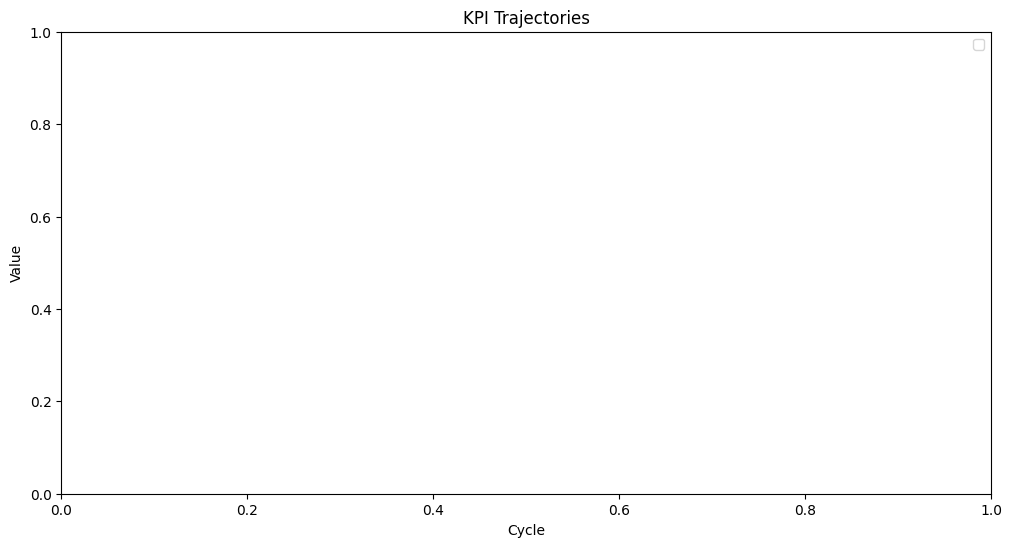

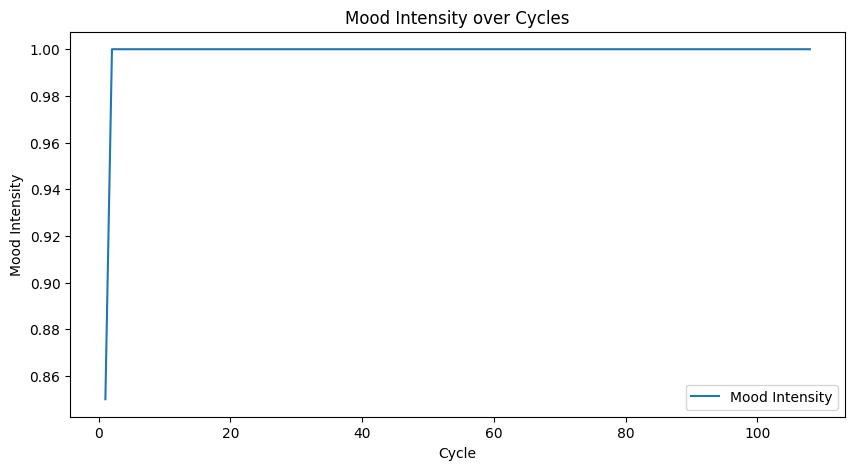

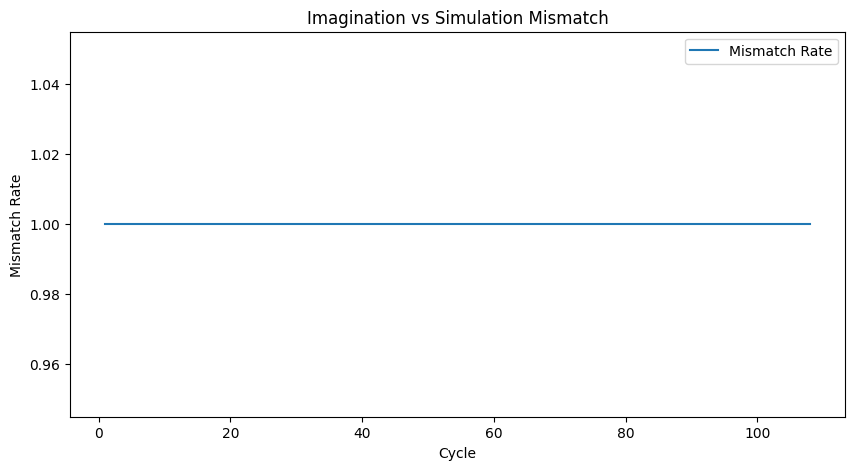

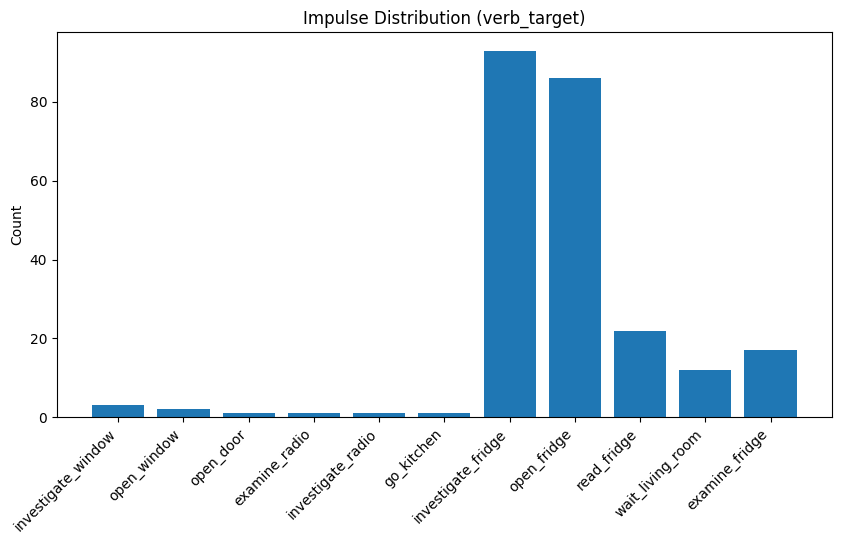

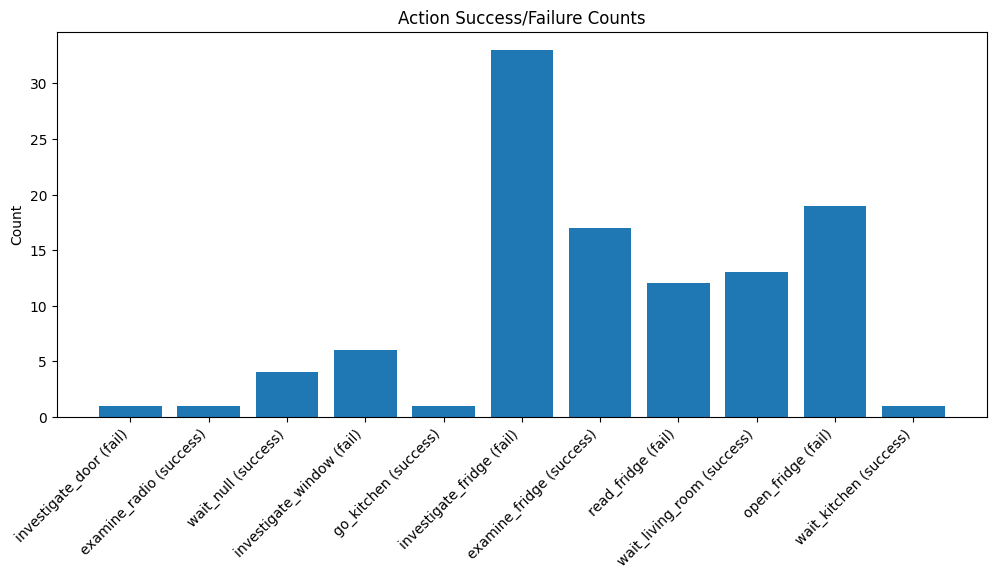

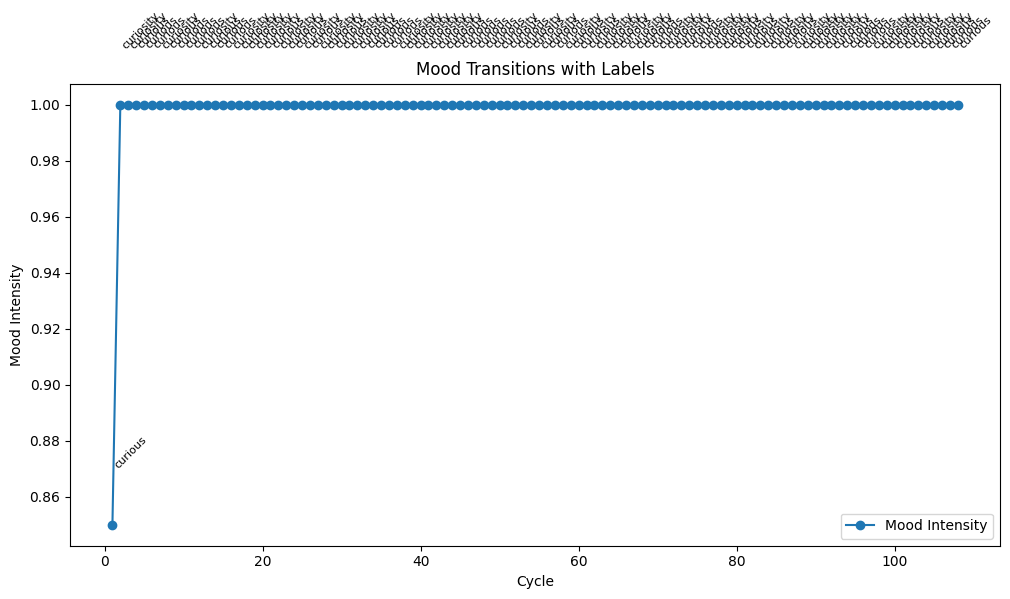

In [23]:

# --- Unified Data Preparation Wrapper ---

import pandas as pd
import json

def prepare_dataframe(csv_path):
    """Load Adam's behavior CSV, assign headers, parse JSON columns, and compute mismatch rate."""
    headers = [
        "timestamp", "cycle_num", "experiment_tag", "agent_id", "world_time",
        "location", "mood", "mood_intensity",
        "sensory_events", "resonant_memories", "impulses", "chosen_action", "action_result",
        "imagined_outcomes", "simulated_outcomes", "emotional_delta", "kpis", "snapshot"
    ]
    df = pd.read_csv(csv_path, names=headers, header=None)
    df = clean_dataframe(df)

    # Compute mismatch_rate
    def mismatch_rate(row):
        try:
            imagined = json.loads(row["imagined_outcomes"])
            simulated = json.loads(row["simulated_outcomes"])
            return sum(1 for i, s in zip(imagined, simulated) if i != s) / max(1, len(imagined))
        except Exception:
            return None

    df["mismatch_rate"] = df.apply(mismatch_rate, axis=1)
    return df

# Example usage:
df = prepare_dataframe("adam_behavior_log.csv")
experiment_dashboard(df)
